# 04_Flood_Depth_Estimation: Trucks

This model heavily leverages the work of the VGG-16 model, published as

Very Deep Convolutional Networks for Large-Scale Image Recognition    
K. Simonyan, A. Zisserman    
arXiv:1409.1556

In addition, implementation and enhancement examples from the following sources were used:

 - https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
 
In addition to the excellent advice in several of these sources, we have modified the code, built additional utilities, and generally customized everything.

## Contents:    
 - Notebook Setup
 - Image Setup
 - Model Build
 - Model Train
 - Model Evaluation
 - Preliminary Model Test

## Import

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


## Global settings

In [2]:
# These are the settings to adjust as new models are tried
model_name_for_saving = 'vgg16_truck_2_v2_epoch5.h5'

In [3]:
# Images for training the model
train_dir = '../images/truck/train'

# Images for validating the model (testing it during the training phases)
validate_dir = '../images/truck/validate'

# After the model has been built, try it out on a few images it hasn't seen
image_test_dir = '../images/truck/test'

## Utility functions

In [4]:
# Remove .DS_store from the list of files in a directory
def rm_DS(mlist): 
    if ('.DS_Store' in mlist): mlist.remove('.DS_Store')
    return mlist

## Image setup

The folder structure beneath each of the train, validate, and test directories is identical, and each folder represents a category for classification.

We have standardized on estimating flood depths as

|Category|Meaning|
|---|---|
|depth_0| No water, or surface water on the order of 1 inch.|
|depth_1| 1 foot, or approximately the middle of a hubcap.|
|depth_2| 2 feet, or approximately the top of a tire.|
|depth_3| 3 feet, or roughly just below the rear view mirrors or the top of the door.|
|depth_4| 4 feet, or above the truck bed but below the roof line.|

In [5]:
!ls {train_dir}  # folders in the train_dir indicate the classification categories 

depth_0 depth_1 depth_2 depth_3 depth_4


In [6]:
# Programmatically get the class labels from the training directory
category_list = rm_DS(os.listdir(image_test_dir))
labels = sorted(category_list)
num_categories = len(labels)

print(f"Classification labels to predict: {labels}")

Classification labels to predict: ['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


In [25]:
# Count the number of images in each category

image_train_dirs = os.listdir(train_dir)

category_dict = dict()
total_images = 0

for itdir in image_train_dirs:
    checkdir = train_dir + '/' + itdir
    if (itdir != '.DS_Store'):
        num_images = len(os.listdir(checkdir))
        category_dict[itdir] = num_images
        total_images += num_images
        
print(f"Total images: {total_images}")
baseline = 0
for k,v in category_dict.items():
    prcnt = round(100*v/total_images,1)
    print(f"Category {k} has {v: 3d} images or {prcnt}% of the images.")
    if prcnt > baseline: baseline = prcnt
        
print(f"\nBaseline accuracy: {baseline}%")
print(f"(accuracy achieved by simply guessing the most populous category)")

Total images: 71
Category depth_2 has  15 images or 21.1% of the images.
Category depth_3 has  13 images or 18.3% of the images.
Category depth_4 has   9 images or 12.7% of the images.
Category depth_1 has  26 images or 36.6% of the images.
Category depth_0 has   8 images or 11.3% of the images.

Baseline accuracy: 36.6%
(accuracy achieved by simply guessing the most populous category)


## Image pre-processing

The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

Problem -- for some reason, this seems to expect the data to be in separate directories for 'cat' or 'dog' under the train and test folders. See the image in this folder

<img src="../images/dogs-vs-cats/tds_folder_structure.png" alt="folder structure" width="750"/>

Inspiration for ways to augment a small data set:
    
 - https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
    
 - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html   

In [8]:
# The bulk of the images are in this training set
trdata = ImageDataGenerator(
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rotation_range=4,
                            horizontal_flip=True
)
traindata = trdata.flow_from_directory(directory=train_dir, target_size=(224,224))


# This data is used to validate the model during training
tsdata = ImageDataGenerator(
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rotation_range=4,
                            horizontal_flip=True
                           )
testdata = tsdata.flow_from_directory(directory=validate_dir, target_size=(224,224))

Found 71 images belonging to 5 classes.
Found 13 images belonging to 5 classes.


In [9]:
base_test_images = len(testdata.next()[0])
base_test_images

13

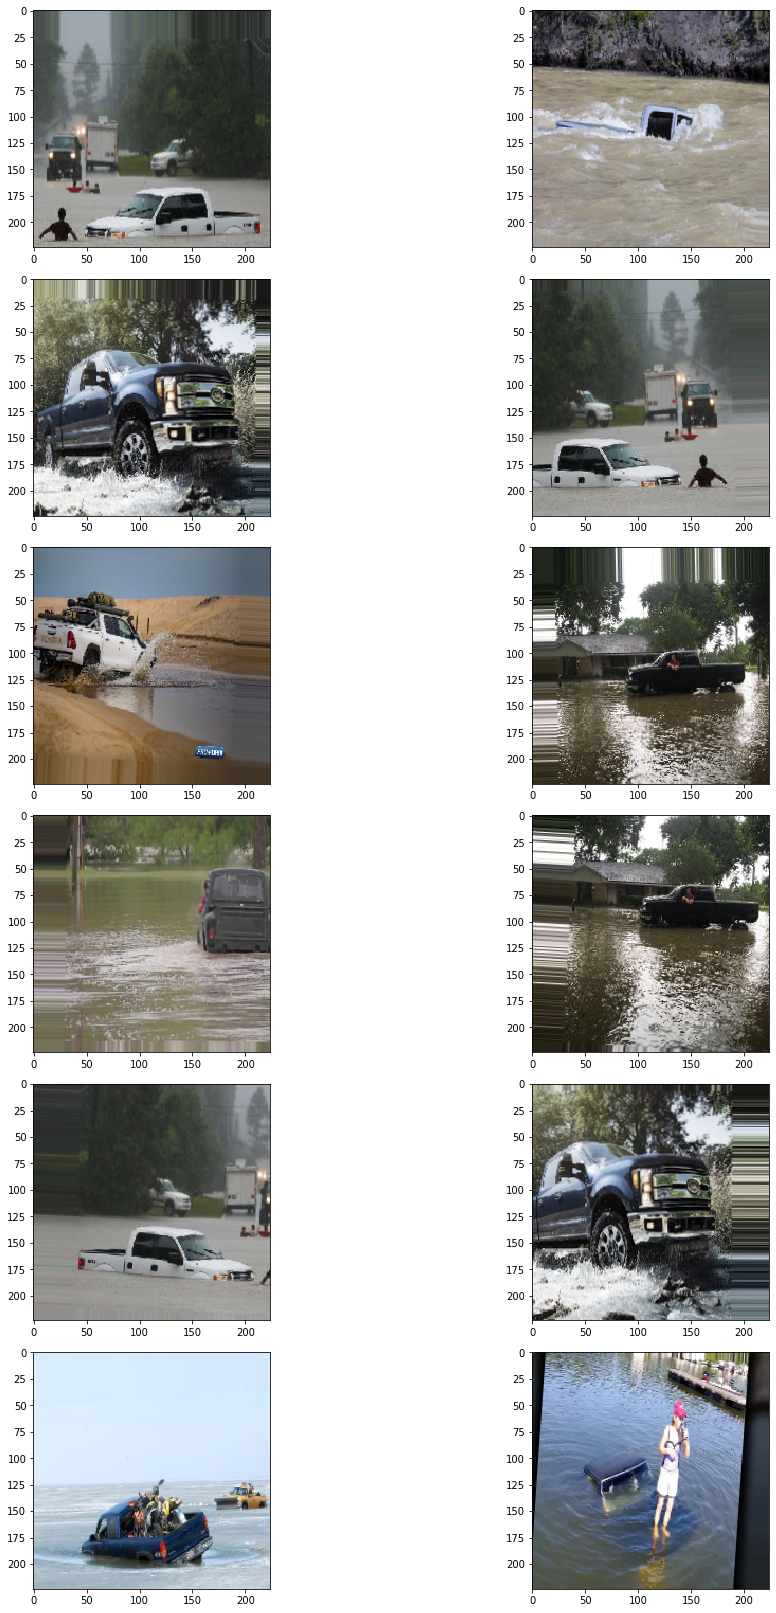

In [10]:
num_test_images = base_test_images

# take a quick look at the the testdata images
fig = plt.figure(figsize=(14,2*num_test_images))

#it = testdata.flow(batch_size=1)
img_count = 1;

for i in range(num_test_images-1):
    ax = fig.add_subplot((num_test_images/2)+1,2,img_count)
    
    getphoto = testdata.next()
    getimg = getphoto[0].astype('uint8')[img_count]
    ax.imshow(getimg)
    img_count += 1
plt.tight_layout()
    

# Build the model

Here I have started with initialising the model by specifying that the model is a sequential model. After initialising the model I add
→ 2 x convolution layer of 64 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 2 x convolution layer of 128 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 256 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
I also add relu(Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer.

In [11]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", 
                 activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

After creating all the convolution I pass the data to the dense layer so for that 
I flatten the vector which comes out of the convolutions and add    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense Softmax layer of 2 units    
I will use RELU activation for both the dense layer of 4096 units so that I stop 
forwarding negative values through the network. I use a 2 unit dense layer in the 
end with softmax activation as I have 2 classes to predict from in the end which are dog and cat. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.

In [12]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_categories, activation="softmax")) # needs to be the same as the num classes

At the end of the cell above, the "softmax" activation layer contains the name number of nodes as the 'num_categories', and this is where the final classification will occur. At this point, the model layers have been built. The next step is to compile the model.

In [13]:
# Compile the model with the model parameters
opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']                        # other metrics to produce
             )

'Adam' is a popular optimiser for finding the global minimum of the loss function.

The learning rate may be adjusted 
- lower, if the results are changing drastically from epoch to epoch
- higher, if the model runs for a very long time and doesn't make very much progress from epoch to epoch

During development, we tried

- 0.001

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

After the creation of the model I will import ModelCheckpoint and EarlyStopping method from keras. I will create an object of both and pass that as callback functions to fit_generator.    

ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. The model will only be saved to disk if the validation accuracy of the model in current epoch is greater than what it was in the last epoch.    

EarlyStopping helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation accuracy by passing val_acc to EarlyStopping. I have here set patience to 20 which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 20 epochs.    

I am using model.fit_generator as I am using ImageDataGenerator to pass data to the model. I will pass train and test data to fit_generator. In fit_generator steps_per_epoch will set the batch size to pass training data to the model and validation_steps will do the same for test data. You can tweak it based on your system specifications.
After executing the above line the model will start to train and you will start to see the training/validation accuracy and loss.

In [15]:
# Fit the model

# Set up some early stopping points just in case they are handy

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, 
                      verbose=1, mode='auto')

use_epochs = 12 # original had 100
#steps_per_epoch = train_images / use_epochs # or leave it blank

hist = model.fit_generator(
                        #steps_per_epoch=use_epochs,
                           generator=traindata, 
                           validation_data= testdata, 
                           validation_steps=10,epochs=use_epochs
                           #callbacks=[checkpoint,early]
                    )

Epoch 1/12
3/3 [==============================] - 29s 10s/step - loss: 5910.4963 - accuracy: 0.2394 - val_loss: 1.5996 - val_accuracy: 0.1538
Epoch 2/12
3/3 [==============================] - 29s 10s/step - loss: 1.6817 - accuracy: 0.2113 - val_loss: 1.5959 - val_accuracy: 0.1538
Epoch 3/12
3/3 [==============================] - 29s 10s/step - loss: 1.6836 - accuracy: 0.3239 - val_loss: 1.5008 - val_accuracy: 0.1538
Epoch 4/12
3/3 [==============================] - 30s 10s/step - loss: 1.6442 - accuracy: 0.3099 - val_loss: 1.5482 - val_accuracy: 0.1538
Epoch 5/12
3/3 [==============================] - 30s 10s/step - loss: 1.5714 - accuracy: 0.3662 - val_loss: 1.6298 - val_accuracy: 0.1538
Epoch 6/12
3/3 [==============================] - 30s 10s/step - loss: 1.5489 - accuracy: 0.3662 - val_loss: 1.9665 - val_accuracy: 0.1923
Epoch 7/12
3/3 [==============================] - 30s 10s/step - loss: 1.6621 - accuracy: 0.3803 - val_loss: 1.6286 - val_accuracy: 0.1538
Epoch 8/12
3/3 [========

## Evaluate the model

Once you have trained the model you can visualise training/validation accuracy and loss. As you may have noticed I am passing the output of mode.fit_generator to hist variable. All the training/validation accuracy and loss are stored in hist and I will visualise it from there.

In [16]:
type(hist)

keras.callbacks.callbacks.History

In [17]:
hist.history

{'val_loss': [1.5995978116989136,
  1.5959059000015259,
  1.5008091926574707,
  1.548188328742981,
  1.6297863721847534,
  1.9665238857269287,
  1.6285818815231323,
  1.9349068403244019,
  1.609175205230713,
  1.5583651065826416,
  1.5041548013687134,
  1.4168328046798706],
 'val_accuracy': [0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.19230769574642181,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.4769230782985687,
  0.4615384638309479],
 'loss': [7344.513197919013,
  1.7033267978211524,
  1.7044155060405461,
  1.6467777557776009,
  1.565948593784386,
  1.5497181768148718,
  1.6885635198002131,
  1.5428793615018819,
  1.8684736473459593,
  1.564719020480841,
  1.5512711514889355,
  1.5647187787042538],
 'accuracy': [0.23943663,
  0.2112676,
  0.32394367,
  0.30985916,
  0.36619717,
  0.36619717,
  0.3802817,
  0.36619717,
  0.36619717,
  0.36619717,
  0.36619717,
  0.19718

(0, 20)

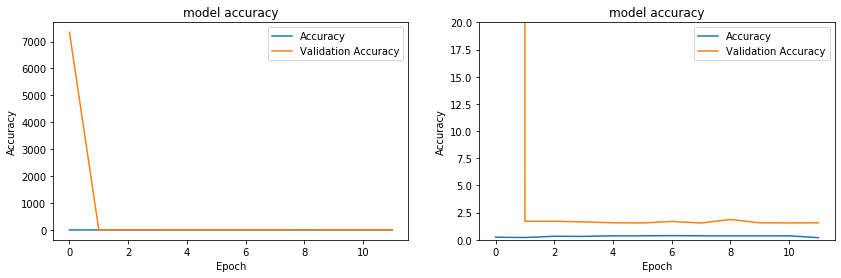

In [18]:
# Plot the coarse and fine versions of the model improvements

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,1)

#plt.plot(hist.history["acc"])
ax1.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax1.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
ax1.set_title("model accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

ax2 = fig.add_subplot(1,2,2)

#plt.plot(hist.history["acc"])
ax2.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax2.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
ax2.set_title("model accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
ax2.set_ylim(0,20)

In [19]:
# save the model
model.save(filepath=model_name_for_saving)

## Utilities for predictions

In [20]:
# Show the images with the Actual and Predicted classifications
def evaluate_test_images(cat,image_test_dir,image_list):
    '''cat : name of image category
       img_list: list of images that should be in that category'''

    tot_images = len(image_list)
    tot_div_2 = (tot_images/2)+1

    fig = plt.figure(figsize=(14,4*tot_div_2)) # size for 2 columns

    img_num = 1
    ax_list = []
    fontsize = 20
    tot_images = len(image_list)

    for img_file in image_list:
        use_image = image_test_dir + '/' + img_file
        ax = fig.add_subplot(tot_div_2,2,img_num)

        img = image.load_img(use_image,target_size=(224,224))
        img = np.asarray(img)

        plt.imshow(img)

        img = np.expand_dims(img, axis=0)
        output = saved_model.predict(img)
        best_match = np.argmax(output)

        title_str = "Actual: " + cat + '\n' + "Predicted: " + labels[best_match]
        ax.set_title(title_str,fontsize=fontsize)
        ax_list.append(ax)
        img_num += 1

        plt.tight_layout()

# Predictions

To do predictions on the trained model, we will
- load the best saved model 
- pre-process the image 
- pass the image to the model to get the prediction
- display the model with the actual category and the predicted category

In [21]:
saved_model = load_model(model_name_for_saving)

In [22]:
print(f"Checking the model on images in the test directory with catgories: \n\n{labels}")

Checking the model on images in the test directory with catgories: 

['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4']


Category depth_0 has 1 test images.
Category depth_1 has 1 test images.
Category depth_2 has 2 test images.
Category depth_3 has 2 test images.
Category depth_4 has 2 test images.


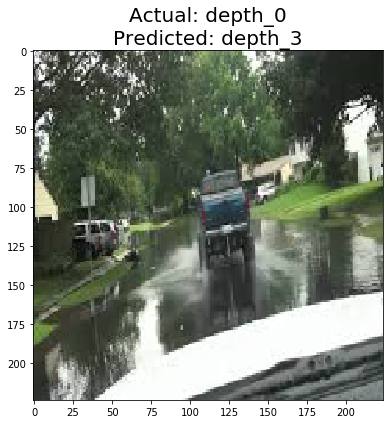

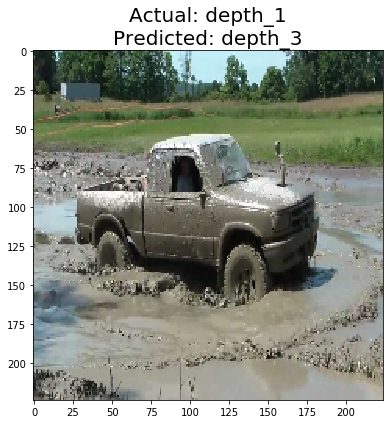

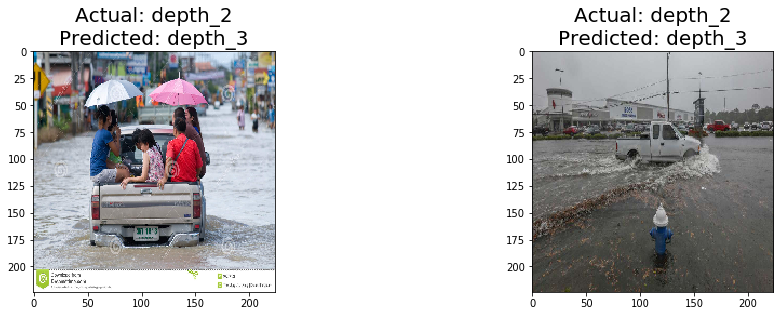

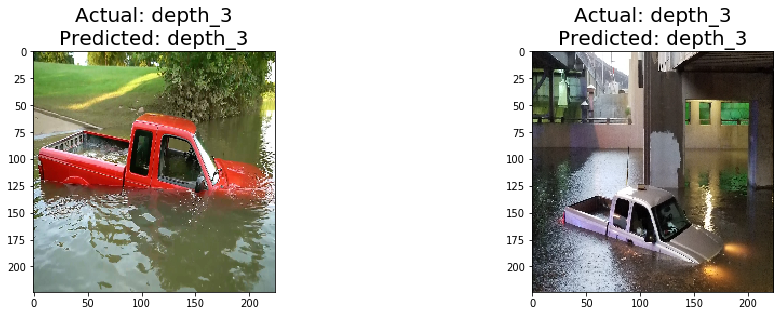

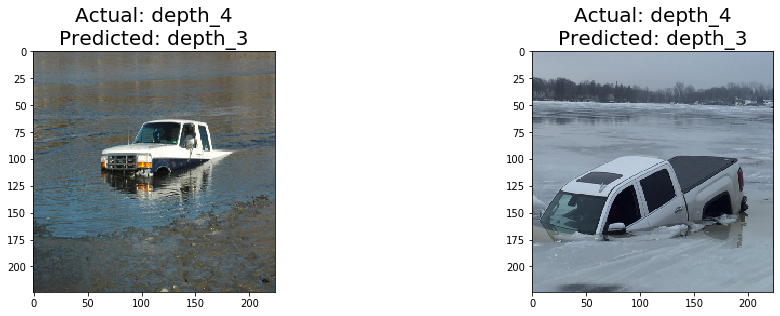

In [23]:
for caty in labels:
    category_dir = image_test_dir + '/' + caty
    img_list = rm_DS(os.listdir(category_dir))
    print(f"Category {caty} has {len(img_list)} test images.")
    evaluate_test_images(caty,category_dir,img_list)